Projet 4 - Anticipez les besoins en consommation de bâtiments - Prediction 1
# 1. Initialisation

In [1]:
target1 = 'SiteEUIWN(kBtu/sf)'
#target1 = 'GHGEmissionsIntensity'

>>-
## 11. Package imports

In [2]:
import numpy as np              # fast thus always used
import pandas as pd             # fast
pd.set_option("display.max_rows", 20, "display.max_columns", None)
import matplotlib.pyplot as plt # slow: 233 ns
import seaborn as sns           # SLOW BUT: 80.4 ns
cmaps = ['vlag', 'twilight_shifted', 'RdBu_r', 'coolwarm', 'seismic', 'rainbow', 'Greys_r']
import re
import my
import math
import timeit
from scipy import interpolate   # FAST BUT: 319 ns ± 2.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
#  %timeit import geopandas     # SLOW 
#import os
#import sys
from IPython.display import clear_output
import warnings

>>-
## 12. Data imports

In [3]:
df = pd.read_csv('df6.csv') #, sep='\t')
try:
    df = df.drop('Unnamed: 0', axis=1)
    print("C'est bon j'ai supprimé la colonne 'Unnamed: 0' qui ne devrait pas exister.")
except:
    print("Y'avait pas de colonne 'Unnamed: 0'")

C'est bon j'ai supprimé la colonne 'Unnamed: 0' qui ne devrait pas exister.


In [4]:
cols_cat = []
with open("cols_cat.txt", "r") as f:
    for line in f:
        cols_cat.append(line.strip())

In [5]:
cols_num = []
with open("cols_num.txt", "r") as f:
    for line in f:
        cols_num.append(line.strip())

>-
# 2. Régressions

>>-
## 2.1. Initialisation

In [6]:
from sklearn.model_selection import train_test_split

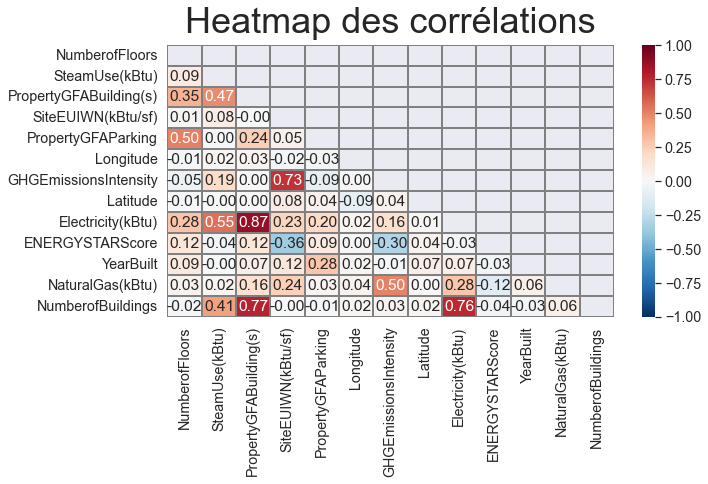

In [7]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.3)
crrl = df.loc[:,cols_num].corr()
corrlmap = sns.heatmap(crrl, mask = np.triu(crrl), vmin=-1, vmax=1, annot=True, cmap=cmaps[2], fmt='3.2f', linewidths=0.01, linecolor='gray', cbar=True, )
corrlmap.set_title('Heatmap des corrélations', fontdict={'fontsize':36}, pad=12)
plt.savefig('corrlmap2.png', dpi=300, bbox_inches='tight')

Ici on a un premier indice du fait que l'ENERGYSTARScore est très important car c'est l'indicateur le plus (anti) corrélé à nos targets.

In [8]:
#ztr, zts = train_test_split(df, test_size=0.2, random_state=5)
drops = ['SiteEUIWN(kBtu/sf)','ENERGYSTARScore','GHGEmissionsIntensity']
X = df.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)
y = df[target1]
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder # not LabelEncoder
#from category_encoders import TargetEncoder # not TargetEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNetCV, LinearRegression # not LogisticRegression car il fait de la classification, pas de la régression.
from sklearn import set_config, svm
set_config(display="diagram")
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import shap
shap.initjs()

J'avais déjà imputé toutes les valeurs manquantes donc le SimpleImputer ne sert à rien ici, c'est juste pour utiliser les pipelines.

In [10]:
def pipeline_t(i, j, k):
    ppln_num = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', j)])
    ppln_cat = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', i)])
    preprocessor = ColumnTransformer(transformers=[('num', ppln_num, cols_num), ('cat', ppln_cat, cols_cat)])
    #model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', k)]) # Ne fonctionne pas car le nom de la step de l'estimateur doit à chaque fois correspondre exactement au nom de l'estimateur.
    k_lowercase = str(k)
    k_lowercase = k_lowercase.lower()[:-2]
    model = Pipeline(steps=[('preprocessor', preprocessor), (k_lowercase, k)])
    return model

In [11]:
pt110 = [.1, .3, 1, 3, 10]
dfpar = pd.DataFrame(columns=['estimator','param_names','param_nums'])
dfpar.loc[0] = [Ridge(), ['ridge__alpha'], [pt110]]
dfpar.loc[1] = [Lasso(), ['lasso__alpha'], [pt110]]
dfpar.loc[2] = [DummyRegressor(), ['dummyregressor__strategy'], [["mean"],["median"]]]
dfpar.loc[3] = [LinearRegression(), ['linearregression__fit_intercept'], [[True]]]
dfpar.loc[4] = [ElasticNetCV(), ['elasticnetcv__l1_ratio','elasticnetcv__n_alphas'], [[.1, .3, 1],[30, 100]]]
#dfpar.loc[5] = [svm.SVR(kernel='linear'), , ['0']]
#dfpar.loc[6] = [LogisticRegression(), ['logisticregression__class_weight'], [["balanced"]]] # LogisticRegression fait de la classification, pas de la régression.
dfpar

,estimator,param_names,param_nums
0,Ridge(),[ridge__alpha],"[[0.1, 0.3, 1, 3, 10]]"
1,Lasso(),[lasso__alpha],"[[0.1, 0.3, 1, 3, 10]]"
2,DummyRegressor(),[dummyregressor__strategy],"[[mean], [median]]"
3,LinearRegression(),[linearregression__fit_intercept],[[True]]
4,ElasticNetCV(),"[elasticnetcv__l1_ratio, elasticnetcv__n_alphas]","[[0.1, 0.3, 1], [30, 100]]"


In [12]:
params = [{dfpar.loc[j, 'param_names'][i]: dfpar.loc[j, 'param_nums'][i] for i in range(len(dfpar.loc[j, 'param_names']))} for j in range(dfpar.shape[0])]
params

[{'ridge__alpha': [0.1, 0.3, 1, 3, 10]},
 {'lasso__alpha': [0.1, 0.3, 1, 3, 10]},
 {'dummyregressor__strategy': ['mean']},
 {'linearregression__fit_intercept': [True]},
 {'elasticnetcv__l1_ratio': [0.1, 0.3, 1],
  'elasticnetcv__n_alphas': [30, 100]}]

In [13]:
encoders = [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), OneHotEncoder(sparse=False,handle_unknown='ignore')] # J'ai pris sparse=False pour faciliter l'utilisation de shap. Tout le reste du notebook fonctionne avec la sparse matrix.
scalers = [RobustScaler(), StandardScaler()]
estimators = list(dfpar['estimator'])

Je ne suis pas très content de la solution handle_unknown='ignore' aveugle.  
Dans une situation réelle j'aurais pris le temps de nettoyer les entrées problématiques (nunique() < 3 par exemple) pour ne pas avoir à utiliser le handle_unknown='ignore'.  
(attention nunique sur le df donne le nombre d'uniques différents par colonne, je ne sais pas si nunique dans une colonne donne ce que je veux, à savoir le nombre d'occurence de chaque unique dans cette colonne)

Le handle_unknown=ignore ne me plaît pas du tout, autant modifier les valeurs de tous les uniques qui sont uniques (voire même tous les uniques qui sont seulement en x2 ou x3 aussi) en 'other'.

Je n'ai toujours pas supprimé les outliers donc StandardScaler sera mauvais pour l'instant.

In [14]:
#print(Xtr['ZipCode'].unique())
#print(Xts['ZipCode'].unique())

<img src="Screenshot_2022-09-01_070904.png"/>

L'OHE me retourne un nombre de colonnes différent pour les tr set et ts set car il ne voit pas les mêmes valeurs unique() notamment dans 'ZipCode', donc le modèle n'arrive pas à travailler sur le ts set après avoir fit le tr set, donc je dois faire le OHE avant de ttsplit à mon avis.
MachineLearnia propose dans l'ordre: ttsplit, Encoder, Scaler, Imputer, Selection, Extraction. ((PolynomialFeatures(), StandardScaler(), SGDClassifier(random_state=0)))
J'étais en train de faire: feature_selection à la main, Imputers (3), ttsplit, Scaler, Encoder, feature_selection (KBest)

Comment justifier que ridge moins complexe que lasso ? etc  
voir pour tree regressor

>>-
## 2.2. Recherche du meilleur estimateur

In [15]:
warnings.filterwarnings('ignore')
dfscores = pd.DataFrame(columns=['Encoder','Scaler','Estimator','best score','r2','mae','msqe','time','best_params','best_estimator'])
m = 0
for i in encoders:
    for j in scalers:
        for k_index, k in enumerate(estimators):
            start_time = timeit.default_timer()
            model = pipeline_t(i, j, k)
            #grid = GridSearchCV(model, param_grid=params[k_index], cv=5, refit=False
            #                   , scoring={'s_r2':'r2','s_nrmse':'neg_root_mean_squared_error','s_me':'max_error','s_ev':'explained_variance'})
            #grid = GridSearchCV(model, param_grid=params[k_index], cv=5, refit='r2' #refit=True False 'r2'
            #                   , scoring={'s_r2':'r2','s_nrmse':'neg_root_mean_squared_error'}) # Ne fonctionne pas car il considère que je n'ai pas spécifié refit.
            grid = GridSearchCV(model, param_grid=params[k_index], cv=5, scoring='r2')
            grid.fit(Xtr, ytr)
            ypred = grid.predict(Xts)
            time_passed = timeit.default_timer() - start_time
            cell_pn = dfpar.loc[k_index, 'param_nums']
            param_loops = math.prod([len(cell_pn[i]) for i in range(len(cell_pn))])
            time_1 = time_passed/(param_loops)
            dfscores.loc[m] = [i, j, k, grid.best_score_, r2_score(yts, ypred), mean_absolute_error(yts, ypred), mean_squared_error(yts, ypred), time_1, grid.best_params_, grid.best_estimator_]
            clear_output()
            print(str(100*m/(len(encoders)*len(scalers)*len(estimators))) + '%')
            m += 1
clear_output()
display(dfscores)

,Encoder,Scaler,Estimator,best score,r2,mae,msqe,time,best_params,best_estimator
0,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Ridge(),1.279617e-01,-1.670998e+00,4.305065e+01,1.303636e+04,0.076257,{'ridge__alpha': 10},"(ColumnTransformer(transformers=[('num',\n ..."
1,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Lasso(),2.896550e-01,-1.192557e+00,4.271999e+01,1.070123e+04,0.080986,{'lasso__alpha': 10},"(ColumnTransformer(transformers=[('num',\n ..."
2,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),DummyRegressor(),-2.075314e-03,-4.763885e-04,4.547045e+01,4.883032e+03,0.092554,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
3,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),LinearRegression(),1.182682e-01,-1.674003e+00,4.305699e+01,1.305103e+04,0.098484,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
4,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),ElasticNetCV(),-6.414048e-03,-4.763885e-04,4.547045e+01,4.883032e+03,0.194261,"{'elasticnetcv__l1_ratio': 0.1, 'elasticnetcv_...","(ColumnTransformer(transformers=[('num',\n ..."
5,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),Ridge(),1.941123e-01,-1.595599e+00,4.318787e+01,1.266835e+04,0.076156,{'ridge__alpha': 10},"(ColumnTransformer(transformers=[('num',\n ..."
6,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),Lasso(),3.179812e-01,-1.104182e+00,4.333398e+01,1.026989e+04,0.076839,{'lasso__alpha': 3},"(ColumnTransformer(transformers=[('num',\n ..."
7,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),DummyRegressor(),-2.075314e-03,-4.763885e-04,4.547045e+01,4.883032e+03,0.086790,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
8,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),LinearRegression(),1.182682e-01,-1.674003e+00,4.305699e+01,1.305103e+04,0.092014,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
9,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),ElasticNetCV(),2.581814e-01,-6.315699e-01,4.410558e+01,7.963214e+03,0.211204,"{'elasticnetcv__l1_ratio': 0.3, 'elasticnetcv_...","(ColumnTransformer(transformers=[('num',\n ..."


In [16]:
i, j, k # Me donne la loop en cours, en cas d'erreur.

(OneHotEncoder(handle_unknown='ignore', sparse=False),
 StandardScaler(),
 ElasticNetCV())

In [17]:
index_1 = dfscores[dfscores['best score'] == dfscores['best score'].max()].index[0]
#encoder_1, scaler_1, estimator_1, best_params_1, model = dfscores.loc[index_1,['Encoder','Scaler','Estimator','best_params','best_estimator']]
model_best = dfscores.loc[index_1,'best_estimator']
model_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'SteamUse(kBtu)',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'Longitude', 'Latitude',
                                                   'Electricity(kBtu)',
                                                   'YearBuilt',
                                                   'NaturalGas(kBtu)',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'ZipCode',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType'])])),
                ('elasticnetcv', ElasticNetCV(l1_ratio=0.3, n_alphas=30))])

>-
# 3. Pertinence de l'ENERGYSTARScore

>>-
## 3.1. Suppression des données dont l'ENERGYSTARScore n'est pas renseigné.

In [18]:
display(df.shape)
df = df[~df['ENERGYSTARScore'].isna()]
df = my.resindx(df)

(1666, 19)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(1094, 19)


>>-
## 3.2. Performance du best_estimator_ AVEC la feature ENERGYSTARScore

>>>-
### 3.2.1. Performance

In [19]:
drops = ['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity']

In [20]:
cols_num = []
with open("cols_num.txt", "r") as f:
    for line in f:
        cols_num.append(line.strip())

In [21]:
X = df.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)
y = df[target1]
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

Ici je dois absolument reconstruire mon model car sinon il travaillera en ignorant complètement l'ENERGYSTARScore (parce que quand je l'ai fabriqué dans le 2.2 il travaillait sans ENERGYSTARScore).

In [22]:
mb00 = model_best.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder']
mb01 = model_best.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler']
mb1 = model_best[1]
model = pipeline_t(mb00, mb01, mb1)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'SteamUse(kBtu)',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'Longitude', 'Latitude',
                                                   'Electricity(kBtu)',
                                                   'ENERGYSTARScore',
                                                   'YearBuilt',
                                                   'NaturalGas(kBtu)',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'ZipCode',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType'])])),
                ('elasticnetcv(l1_ratio=0.3, n_alphas=3',
                 ElasticNetCV(l1_ratio=0.3, n_alphas=30))])

En cliquant sur num dans les deux outputs ci-dessus et ci-dessous on voit que si j'avais travaillé avec model_best ma pipeline aurait ignoré la colonne ENERGYSTARScore pourtant présente dans X, et qu'en travaillant avec model (que je viens pourtant de construire à partir des éléments de model_best) ma pipeline tient correctement compte de l'indicateur ENERGYSTARScore.

In [23]:
model_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'SteamUse(kBtu)',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'Longitude', 'Latitude',
                                                   'Electricity(kBtu)',
                                                   'YearBuilt',
                                                   'NaturalGas(kBtu)',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'ZipCode',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType'])])),
                ('elasticnetcv', ElasticNetCV(l1_ratio=0.3, n_alphas=30))])

In [24]:
model.fit(Xtr, ytr)
ypred = model.predict(Xts)
r2_E, mae_E, mse_E = r2_score(yts, ypred), mean_absolute_error(yts, ypred), mean_squared_error(yts, ypred)

In [25]:
r2_E, mae_E, mse_E

(0.4083660100279496, 24.128123367813092, 3250.1732253809832)

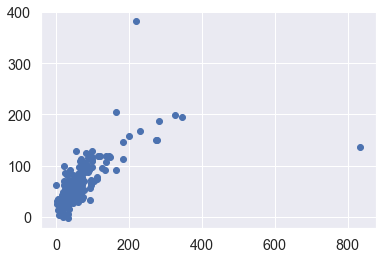

In [26]:
plt.scatter(yts, ypred)

>>>-
### 3.2.2. Comparaison de l'importance de chaque indicateur, avec shap

In [27]:
cols_cat_ohe = model.named_steps['preprocessor'].transformers_[1][1]\
                    .named_steps['encoder'].get_feature_names(cols_cat)

In [28]:
feature_names_2 = np.concatenate((cols_num, cols_cat_ohe),axis=0)

In [29]:
X_mod = model[0].fit_transform(Xtr, ytr)

In [30]:
X_mod = pd.DataFrame(X_mod, index=Xtr.index, columns=feature_names_2)

In [31]:
explainer = shap.Explainer(model[1].predict, X_mod)

In [32]:
shap_values = explainer(X_mod)

Permutation explainer: 876it [00:17, 23.01it/s]                         


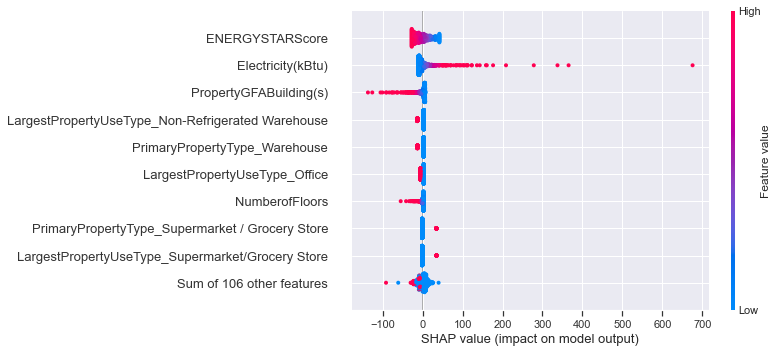

In [33]:
shap.plots.beeswarm(shap_values)
#shap.summary_plot(shap_values)

'ENERGYSTARScore' joue effectivement le rôle le plus important parmi les indicateurs du dataset (2è preuve).

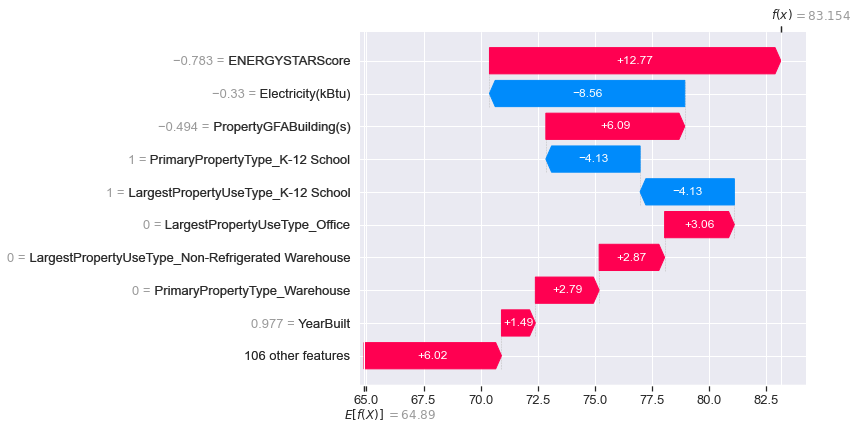

In [34]:
shap.plots.waterfall(shap_values[0])

>>-
## 3.3. Performance du best_estimator_ SANS la feature ENERGYSTARScore.

In [35]:
drops = ['SiteEUIWN(kBtu/sf)','ENERGYSTARScore','GHGEmissionsIntensity']

In [36]:
cols_num = []
with open("cols_num.txt", "r") as f:
    for line in f:
        cols_num.append(line.strip())

In [37]:
X = df.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)
y = df[target1]
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

In [38]:
model = pipeline_t(mb00, mb01, mb1)

In [39]:
model.fit(Xtr, ytr)
ypred = model.predict(Xts)
r2_0, mae_0, mse_0 = r2_score(yts, ypred), mean_absolute_error(yts, ypred), mean_squared_error(yts, ypred)

In [40]:
r2_0, mae_0, mse_0

(0.3537068825302957, 29.24779478711691, 3550.4460895616785)

In [41]:
r2_E-r2_0, mae_E-mae_0, mse_E-mse_0

(0.05465912749765389, -5.119671419303817, -300.27286418069525)

'ENERGYSTARScore' joue effectivement un rôle non-négligeable dans le résultat de la régression (3è preuve).

>-
# 4. Nettoyages supplémentaires pour améliorer les scores de régression

>>-
## 4.1. Passage au log

skewness pour log de certaines features dans la pipeline  

In [42]:
cols_num = []
with open("cols_num.txt", "r") as f:
    for line in f:
        cols_num.append(line.strip())

In [43]:
df10 = pd.DataFrame(columns = ['indicateur','skewness'])
cols_num_log = []
for co in cols_num:
    sk = df[co].skew()
    df10.loc[co] = [co, sk]
    if sk > 1:
        cols_num_log.append(co)
display(df10)
cols_num_lin = list(set(cols_num).difference(set(cols_num_log)))

,indicateur,skewness
NumberofFloors,NumberofFloors,5.106580
SteamUse(kBtu),SteamUse(kBtu),18.518288
PropertyGFABuilding(s),PropertyGFABuilding(s),4.667818
SiteEUIWN(kBtu/sf),SiteEUIWN(kBtu/sf),4.685968
PropertyGFAParking,PropertyGFAParking,4.912275
Longitude,Longitude,0.030541
GHGEmissionsIntensity,GHGEmissionsIntensity,6.380721
Latitude,Latitude,0.174232
Electricity(kBtu),Electricity(kBtu),9.139249
ENERGYSTARScore,ENERGYSTARScore,-0.775344


In [44]:
cols_num_log = list(set(cols_num).difference(set(['Longitude','Latitude','YearBuilt','ENERGYSTARScore'])))
df10 = df.copy()
for co in cols_num_log:
    df10[co] = np.log(df10[co]+1)/np.log(2) # Je mets +1 pour éviter les valeurs <0 et surtout -inf (qui fausse les boxplot et bug avec ).
                                  # Je me permets ce +1 car toutes les cols_num_log ont des valeurs qui évoluent dans une range bien plus "haute" que [0,1].
df10.to_csv('df10.csv')

In [45]:
df = df10.copy()

In [46]:
df10sk = pd.DataFrame(columns = ['indicateur','skewness'])
cols_num_sk = []
for co in cols_num:
    sk = df[co].skew()
    df10sk.loc[co] = [co, sk]
display(df10sk)

,indicateur,skewness
NumberofFloors,NumberofFloors,1.222773
SteamUse(kBtu),SteamUse(kBtu),3.485820
PropertyGFABuilding(s),PropertyGFABuilding(s),0.963639
SiteEUIWN(kBtu/sf),SiteEUIWN(kBtu/sf),-0.835211
PropertyGFAParking,PropertyGFAParking,1.360725
Longitude,Longitude,0.030541
GHGEmissionsIntensity,GHGEmissionsIntensity,1.213944
Latitude,Latitude,0.174232
Electricity(kBtu),Electricity(kBtu),-1.332960
ENERGYSTARScore,ENERGYSTARScore,-0.775344


>>-
## 4.2. Suppression d'outliers
(Je n'en avais supprimé aucun.)

In [47]:
df11_out = pd.DataFrame(columns = ['indicateur','# outliers bas','# outliers hauts'])
cols_num_not_out = ['NumberofFloors','NumberofBuildings','SteamUse(kBtu)','PropertyGFAParking'] # Je ne peux pas supprimer leurs outliers car si je le fais je me retrouve avec une seule valeur unique restante pour ces indicateurs.
cols_num_out = list(set(cols_num).difference(set(cols_num_not_out)))
for co in cols_num_out:
    Q1 = df[co].quantile(.25)
    Q3 = df[co].quantile(.75)
    QQ = 1.5*(Q3 - Q1)
    Qm = Q1 - QQ
    QM = Q3 + QQ
    n_out = sum(df[co] < Qm)
    N_out = sum(df[co] > QM)
    df11_out.loc[co] = [co, n_out, N_out]
    df = df[~((df[co] > QM) | (df[co] < Qm))]
display(df11_out)
df = my.resindx(df)
df.to_csv('df11.csv')
df11 = df.copy()

,indicateur,# outliers bas,# outliers hauts
NaturalGas(kBtu),NaturalGas(kBtu),0,0
Latitude,Latitude,0,0
SiteEUIWN(kBtu/sf),SiteEUIWN(kBtu/sf),51,37
PropertyGFABuilding(s),PropertyGFABuilding(s),0,22
YearBuilt,YearBuilt,0,0
ENERGYSTARScore,ENERGYSTARScore,0,0
GHGEmissionsIntensity,GHGEmissionsIntensity,0,10
Longitude,Longitude,64,62
Electricity(kBtu),Electricity(kBtu),2,0


Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(846, 19)


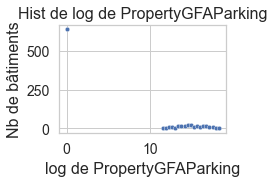

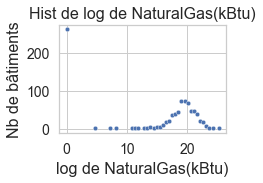

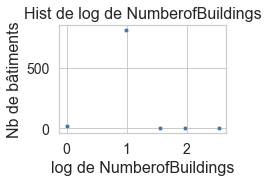

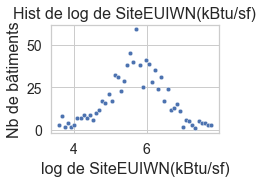

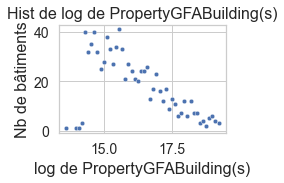

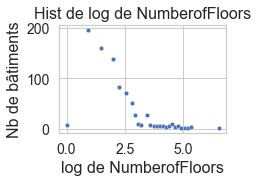

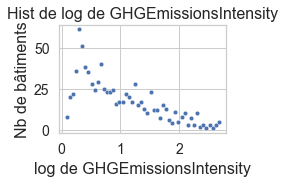

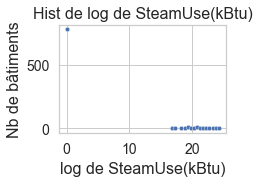

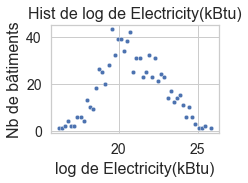

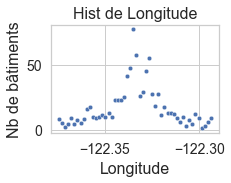

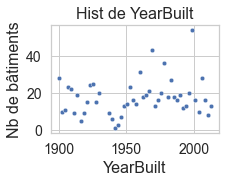

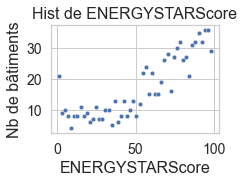

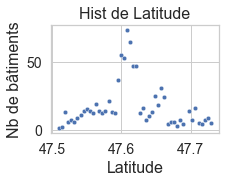

In [48]:
warnings.filterwarnings('ignore')
for co in cols_num_log:
    plt.figure(figsize=(3, 2))
    my.hstplot(df[co], strlog='log de ')
for co in cols_num_lin:
    plt.figure(figsize=(3, 2))
    my.hstplot(df[co], strlog='')
print()

In [49]:
from sklearn.preprocessing import MinMaxScaler

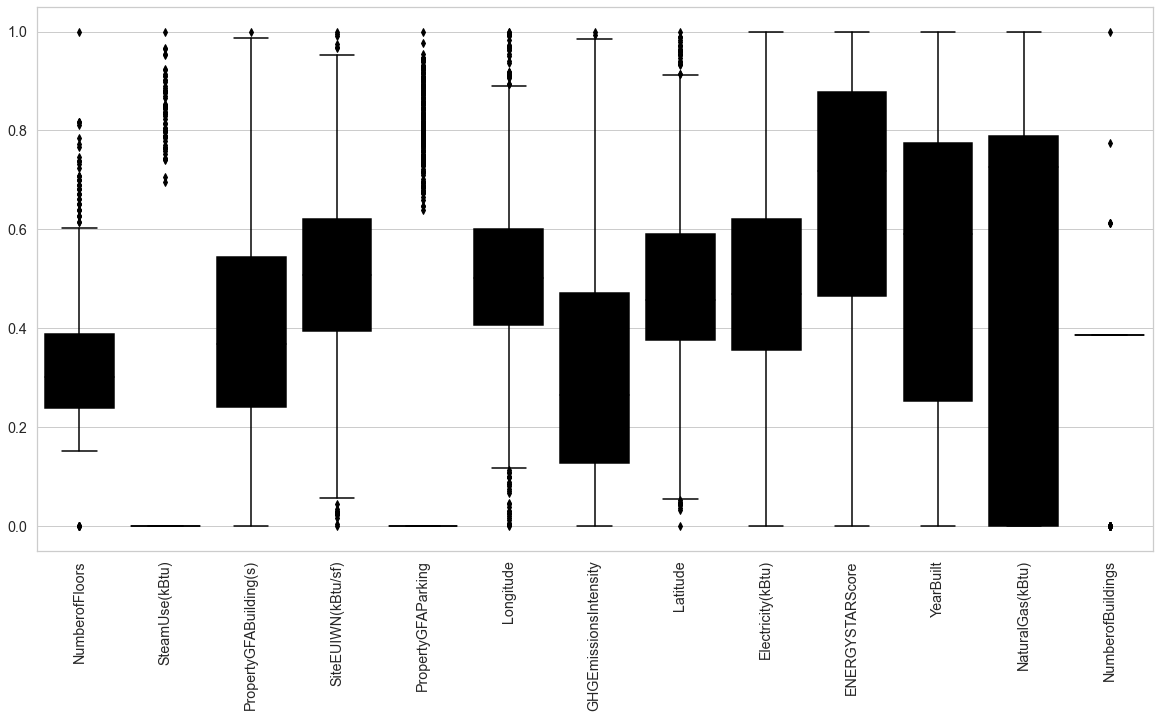

In [50]:
scal = MinMaxScaler()
dfbox = pd.DataFrame(scal.fit_transform(df[cols_num]), index = df.index, columns = cols_num)
plt.figure(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=dfbox, color='black')
plt.xticks(rotation=90)
print('')

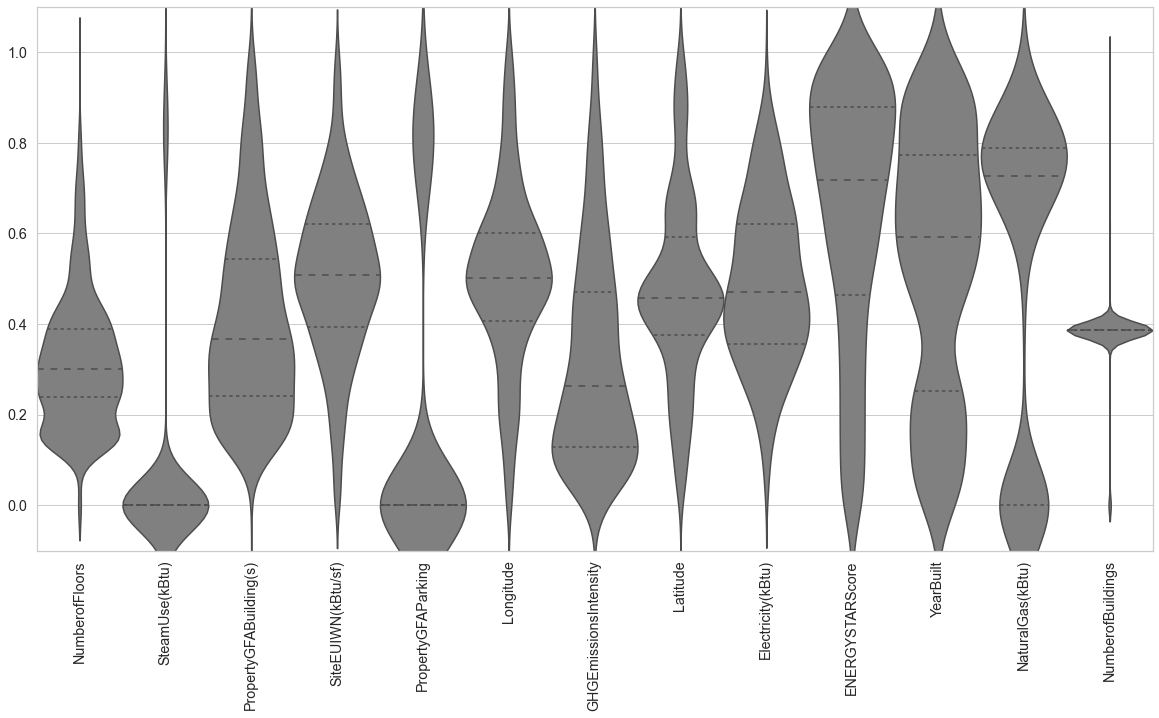

In [51]:
plt.figure(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.violinplot(data=dfbox, color='gray', scale='width', width=1, inner='quartiles')
plt.ylim(-.1,1.1)
plt.xticks(rotation=90)
print('')

>>-
## 4.3. Nouvelle recherche du meilleur estimateur, cette fois en gardant l'ENERGYSTARScore car c'est notre feature la plus importante.

In [52]:
%%script echo Ça ça sert juste à relancer en cas de mauvaise manip.
df = df11.copy()
cols_num = []
with open("cols_num.txt", "r") as f:
    for line in f:
        cols_num.append(line.strip())

Couldn't find program: 'echo'


In [53]:
drops = ['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity']
X = df.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)
y = df[target1]
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

,Encoder,Scaler,Estimator,best score,r2,mae,msqe,time,best_params,best_estimator
0,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Ridge(),6.448975e-01,7.057443e-01,3.471841e-01,1.881953e-01,0.071472,{'ridge__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
1,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Lasso(),3.755796e-01,3.466280e-01,4.903960e-01,4.178730e-01,0.066446,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
2,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),DummyRegressor(),-1.578810e-02,-3.181313e-03,6.169955e-01,6.415983e-01,0.069148,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
3,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),LinearRegression(),6.449006e-01,7.061111e-01,3.470942e-01,1.879607e-01,0.088792,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
4,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),ElasticNetCV(),6.443234e-01,7.032373e-01,3.479353e-01,1.897986e-01,0.212653,"{'elasticnetcv__l1_ratio': 1, 'elasticnetcv__n...","(ColumnTransformer(transformers=[('num',\n ..."
5,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),Ridge(),6.449004e-01,7.059524e-01,3.471420e-01,1.880622e-01,0.069941,{'ridge__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
6,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),Lasso(),4.363796e-01,4.081998e-01,4.676606e-01,3.784939e-01,0.063799,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
7,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),DummyRegressor(),-1.578810e-02,-3.181313e-03,6.169955e-01,6.415983e-01,0.071037,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
8,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),LinearRegression(),6.449006e-01,7.061111e-01,3.470942e-01,1.879607e-01,0.077558,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
9,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),ElasticNetCV(),6.449571e-01,7.028580e-01,3.479119e-01,1.900412e-01,0.274085,"{'elasticnetcv__l1_ratio': 1, 'elasticnetcv__n...","(ColumnTransformer(transformers=[('num',\n ..."


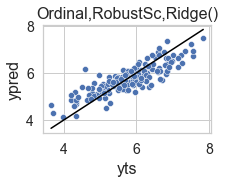

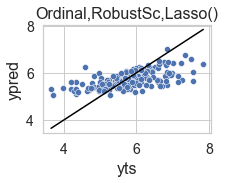

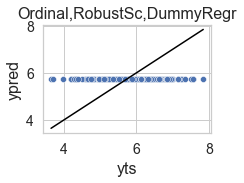

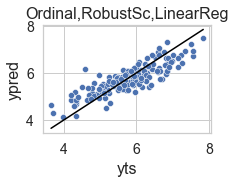

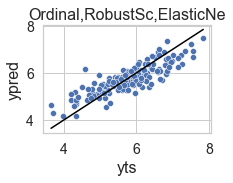

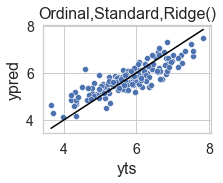

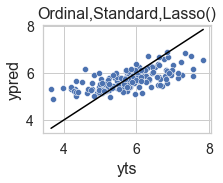

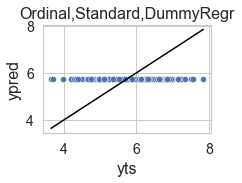

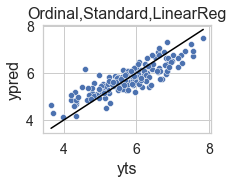

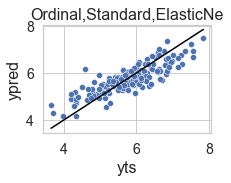

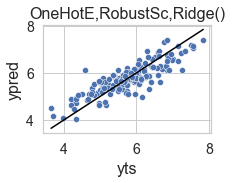

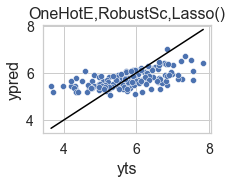

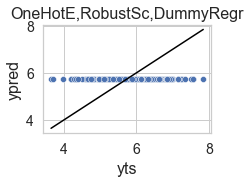

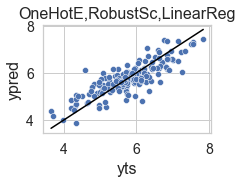

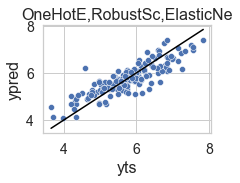

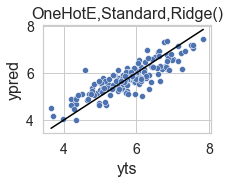

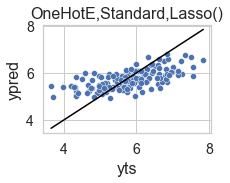

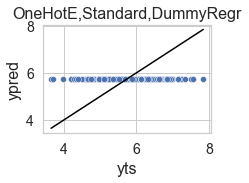

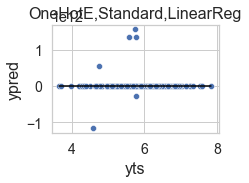

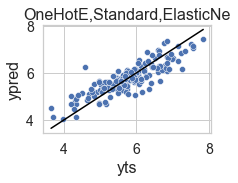

In [54]:
warnings.filterwarnings('ignore')
dfscores2 = pd.DataFrame(columns=['Encoder','Scaler','Estimator','best score','r2','mae','msqe','time','best_params','best_estimator'])
m = 0
for i in encoders:
    for j in scalers:
        for k_index, k in enumerate(estimators):
            start_time = timeit.default_timer()
            model = pipeline_t(i, j, k)
            grid = GridSearchCV(model, param_grid=params[k_index], cv=5, scoring='r2')
            grid.fit(Xtr, ytr)
            ypred = grid.predict(Xts)
            time_passed = timeit.default_timer() - start_time
            cell_pn = dfpar.loc[k_index, 'param_nums']
            param_loops = math.prod([len(cell_pn[i]) for i in range(len(cell_pn))])
            time_1 = time_passed/(param_loops)
            dfscores2.loc[m] = [i, j, k, grid.best_score_, r2_score(yts, ypred), mean_absolute_error(yts, ypred), mean_squared_error(yts, ypred), time_1, grid.best_params_, grid.best_estimator_]
            clear_output()
            print(str(100*m/(len(encoders)*len(scalers)*len(estimators))) + '%')
            m += 1
            plt.figure(figsize=(3, 2))
            with sns.axes_style("whitegrid"):
                sns.scatterplot(yts, ypred, legend=None)
                plt.plot([min(yts), max(yts)], [min(yts), max(yts)], color="black")
            plt.title((str(i)[:7] + "," + str(j)[:8] + "," + str(k)[:9]),fontsize=16)
            plt.xlabel(("yts"),fontsize=16)
            plt.xticks(fontsize=14)
            plt.ylabel("ypred",fontsize=16)
            plt.yticks(fontsize=14)
            plt.legend
clear_output()
display(dfscores2)

In [55]:
index_1 = dfscores2[dfscores2['best score'] == dfscores2['best score'].max()].index[0]
model_best = dfscores2.loc[index_1,'best_estimator']
model_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'SteamUse(kBtu)',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'Longitude', 'Latitude',
                                                   'Electricity(kBtu)',
                                                   'ENERGYSTARScore',
                                                   'YearBuilt',
                                                   'NaturalGas(kBtu)',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'ZipCode',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType'])])),
                ('ridge', Ridge(alpha=3))])

In [56]:
col_score = ['best score','r2','mae','msqe','time']
print(dfscores2[col_score] - dfscores[col_score])

      best score            r2           mae          msqe      time
0   5.169358e-01  2.376743e+00 -4.270347e+01 -1.303617e+04 -0.004785
1   8.592462e-02  1.539185e+00 -4.222960e+01 -1.070081e+04 -0.014540
2  -1.371279e-02 -2.704925e-03 -4.485346e+01 -4.882390e+03 -0.023406
3   5.266324e-01  2.380115e+00 -4.270989e+01 -1.305084e+04 -0.009692
4   6.507375e-01  7.037137e-01 -4.512252e+01 -4.882842e+03  0.018393
5   4.507881e-01  2.301551e+00 -4.284073e+01 -1.266817e+04 -0.006215
6   1.183985e-01  1.512382e+00 -4.286632e+01 -1.026952e+04 -0.013040
7  -1.371279e-02 -2.704925e-03 -4.485346e+01 -4.882390e+03 -0.015753
8   5.266324e-01  2.380115e+00 -4.270989e+01 -1.305084e+04 -0.014456
9   3.867757e-01  1.334428e+00 -4.375767e+01 -7.963024e+03  0.062880
10  3.567130e-01  1.716169e+00 -3.550839e+01 -9.727892e+03  0.024411
11  7.493789e-02  1.232123e+00 -3.469701e+01 -9.289140e+03 -0.008328
12 -1.371279e-02 -2.704925e-03 -4.485346e+01 -4.882390e+03  0.012075
13  6.791923e-01  1.859248e+00 -3.

Je trouve de nouveau que la meilleure pipeline est StandardScaler + OHE + ElasticNetCV.  
J'ai grandement amélioré la performance des prédictions avec ces étapes de nettoyage supplémentaires (sauf pour les DummyRegressor).

Permutation explainer: 677it [00:19, 16.78it/s]                         


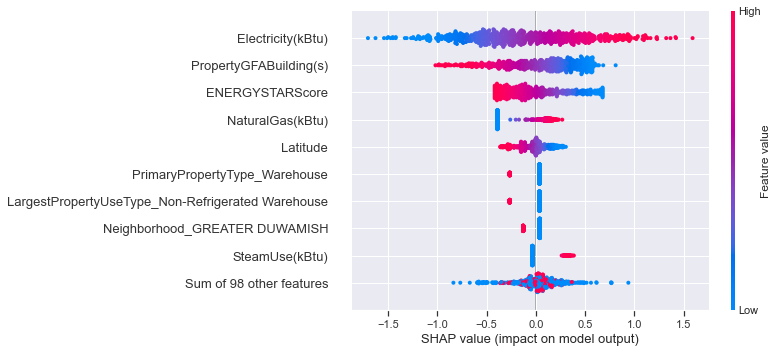

In [57]:
mb00 = model_best.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder']
mb01 = model_best.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler']
mb1 = model_best[1]
model = pipeline_t(mb00, mb01, mb1)
model.fit(Xtr, ytr)
cols_cat_ohe = model.named_steps['preprocessor'].transformers_[1][1]\
                    .named_steps['encoder'].get_feature_names(cols_cat)
feature_names_2 = np.concatenate((cols_num, cols_cat_ohe),axis=0)
X_mod = model[0].fit_transform(Xtr, ytr)
X_mod = pd.DataFrame(X_mod, index=Xtr.index, columns=feature_names_2)
explainer = shap.Explainer(model[1].predict, X_mod)
shap_values = explainer(X_mod)
shap.plots.beeswarm(shap_values)
#shap.summary_plot(shap_values)

>-
# 5. Modifications suite à la soutenance

In [58]:
df = df11.copy()
cols_num = []
with open("cols_num.txt", "r") as f:
    for line in f:
        cols_num.append(line.strip())
cols_cat = []
with open("cols_cat.txt", "r") as f:
    for line in f:
        cols_cat.append(line.strip())

In [59]:
drops = ['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity']
X = df.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)
y = df[target1]

>>-
## 51. Correction de leakage
Les features énergétiques que j'avais gardées mènent à un fort data leakage, et de plus l'approche métier sous-entendure dans ce projet est que l'on veut pouvoir prédire nos targets sans avoir à faire ces trois relevés énergétiques. Je les remplace donc par la simple information "Est-ce que cette énergie est fournie à ce bâtiment ?".

In [60]:
pd.Series([.9, 2]) >= 1

0    False
1     True
dtype: bool

In [61]:
cols = ["SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)"]
for i in cols:
    X[i] = X[i] >= 1
    cols_num.remove(i)
    j = re.sub(r"kBtu", r"y/n", i)
    X.rename(columns={i: j}, inplace=True)
    cols_cat.append(j)

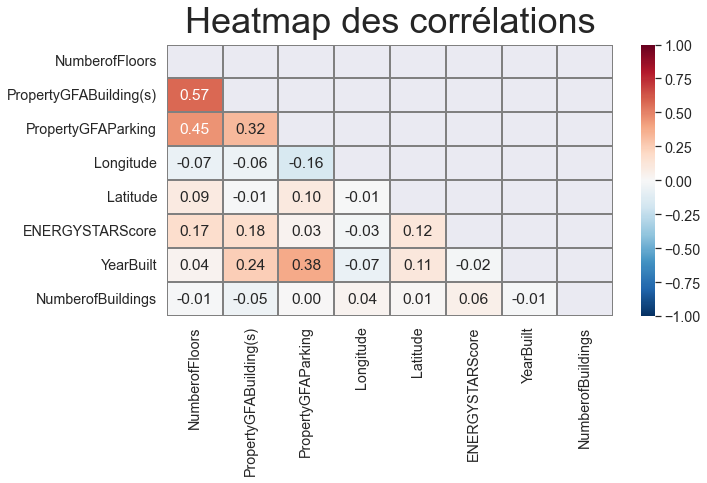

In [70]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.3)
crrl = df.loc[:,cols_num].corr()
corrlmap = sns.heatmap(crrl, mask = np.triu(crrl), vmin=-1, vmax=1, annot=True, cmap=cmaps[2], fmt='3.2f', linewidths=0.01, linecolor='gray', cbar=True, )
corrlmap.set_title('Heatmap des corrélations', fontdict={'fontsize':36}, pad=12)
plt.savefig('corrlmap2.png', dpi=300, bbox_inches='tight')

>>-
## 52. Ajout d'estimateurs non-linéaires (forests)

In [62]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

In [63]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [64]:
pt110 = [.1, .3, 1, 3, 10]
dfpar = pd.DataFrame(columns=["estimator","param_names","param_nums"])
dfpar.loc[0] = [Ridge(), ["ridge__alpha"], [pt110]]
dfpar.loc[1] = [Lasso(), ["lasso__alpha"], [pt110]]
dfpar.loc[2] = [DummyRegressor(), ["dummyregressor__strategy"], [["mean"],["median"]]]
dfpar.loc[3] = [LinearRegression(), ["linearregression__fit_intercept"], [[True]]]
dfpar.loc[4] = [ElasticNetCV(), ["elasticnetcv__l1_ratio","elasticnetcv__n_alphas"], [[.1, .3, 1],[30, 100]]]
dfpar.loc[5] = [RandomForestRegressor(), ["randomforestregressor__max_depth","randomforestregressor__random_state"], [[2],[0]]]
dfpar.loc[6] = [GradientBoostingRegressor(), ["gradientboostingregressor__random_state"], [[0]]]
dfpar.loc[7] = [AdaBoostRegressor(), ["adaboostregressor__n_estimators","adaboostregressor__random_state"], [[30,100],[0]]]
#dfpar.loc[5] = [svm.SVR(kernel="linear"), , ["0"]]
#dfpar.loc[6] = [LogisticRegression(), ["logisticregression__class_weight"], [["balanced"]]] # LogisticRegression fait de la classification, pas de la régression.
dfpar

,estimator,param_names,param_nums
0,Ridge(),[ridge__alpha],"[[0.1, 0.3, 1, 3, 10]]"
1,Lasso(),[lasso__alpha],"[[0.1, 0.3, 1, 3, 10]]"
2,DummyRegressor(),[dummyregressor__strategy],"[[mean], [median]]"
3,LinearRegression(),[linearregression__fit_intercept],[[True]]
4,ElasticNetCV(),"[elasticnetcv__l1_ratio, elasticnetcv__n_alphas]","[[0.1, 0.3, 1], [30, 100]]"
5,RandomForestRegressor(),"[randomforestregressor__max_depth, randomfores...","[[2], [0]]"
6,GradientBoostingRegressor(),[gradientboostingregressor__random_state],[[0]]
7,AdaBoostRegressor(),"[adaboostregressor__n_estimators, adaboostregr...","[[30, 100], [0]]"


In [65]:
params = [{dfpar.loc[j, "param_names"][i]: dfpar.loc[j, "param_nums"][i] for i in range(len(dfpar.loc[j, "param_names"]))} for j in range(dfpar.shape[0])]
params

[{'ridge__alpha': [0.1, 0.3, 1, 3, 10]},
 {'lasso__alpha': [0.1, 0.3, 1, 3, 10]},
 {'dummyregressor__strategy': ['mean']},
 {'linearregression__fit_intercept': [True]},
 {'elasticnetcv__l1_ratio': [0.1, 0.3, 1],
  'elasticnetcv__n_alphas': [30, 100]},
 {'randomforestregressor__max_depth': [2],
  'randomforestregressor__random_state': [0]},
 {'gradientboostingregressor__random_state': [0]},
 {'adaboostregressor__n_estimators': [30, 100],
  'adaboostregressor__random_state': [0]}]

In [66]:
encoders = [OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), OneHotEncoder(sparse=False,handle_unknown="ignore")] # J'ai pris sparse=False pour faciliter l'utilisation de shap. Tout le reste du notebook fonctionne avec la sparse matrix.
scalers = [RobustScaler(), StandardScaler()]
estimators = list(dfpar["estimator"])

>>-
## 53. best_estimator_

In [67]:
warnings.filterwarnings('ignore')
dfscores3 = pd.DataFrame(columns=['Encoder','Scaler','Estimator','best score','r2','mae','msqe','time','best_params','best_estimator'])
m = 0
for i in encoders:
    for j in scalers:
        for k_index, k in enumerate(estimators):
            start_time = timeit.default_timer()
            model = pipeline_t(i, j, k)
            grid = GridSearchCV(model, param_grid=params[k_index], cv=5, scoring='r2')
            grid.fit(Xtr, ytr)
            ypred = grid.predict(Xts)
            time_passed = timeit.default_timer() - start_time
            cell_pn = dfpar.loc[k_index, 'param_nums']
            param_loops = math.prod([len(cell_pn[i]) for i in range(len(cell_pn))])
            time_1 = time_passed/(param_loops)
            dfscores3.loc[m] = [i, j, k,
                                "{a:.2f}".format(a = grid.best_score_),
                                "{a:.2f}".format(a = r2_score(yts, ypred)),
                                "{a:.2f}".format(a = mean_absolute_error(yts, ypred)),
                                "{a:.2f}".format(a = mean_squared_error(yts, ypred)),
                                "{a:.2f}".format(a = time_1),
                                grid.best_params_, grid.best_estimator_]
            clear_output()
            print(str(100*m/(len(encoders)*len(scalers)*len(estimators))) + '%')
            m += 1
            #plt.figure(figsize=(3, 2))
            #with sns.axes_style("whitegrid"):
            #    sns.scatterplot(yts, ypred, legend=None)
            #    plt.plot([min(yts), max(yts)], [min(yts), max(yts)], color="black")
            #plt.title((str(i)[:7] + "," + str(j)[:8] + "," + str(k)[:9]),fontsize=16)
            #plt.xlabel(("yts"),fontsize=16)
            #plt.xticks(fontsize=14)
            #plt.ylabel("ypred",fontsize=16)
            #plt.yticks(fontsize=14)
            #plt.legend
clear_output()
pd.set_option("display.max_rows", 32, "display.max_columns", None)
display(dfscores3.sort_values(by="best score"))

,Encoder,Scaler,Estimator,best score,r2,mae,msqe,time,best_params,best_estimator
0,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Ridge(),0.39,0.37,0.47,0.40,0.08,{'ridge__alpha': 10},"(ColumnTransformer(transformers=[('num',\n ..."
1,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Lasso(),0.29,0.30,0.51,0.45,0.08,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
2,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),DummyRegressor(),-0.02,-0.00,0.62,0.64,0.08,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
3,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),LinearRegression(),0.38,0.37,0.48,0.40,0.09,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
4,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),ElasticNetCV(),0.39,0.37,0.47,0.40,0.26,"{'elasticnetcv__l1_ratio': 0.1, 'elasticnetcv_...","(ColumnTransformer(transformers=[('num',\n ..."
...,...,...,...,...,...,...,...,...,...,...
27,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),LinearRegression(),-67954345857931787894784.00,-21321290515385872809984.00,18417652158.49,13636323023870102601728.00,0.10,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
28,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),ElasticNetCV(),0.60,0.63,0.37,0.24,0.49,"{'elasticnetcv__l1_ratio': 0.3, 'elasticnetcv_...","(ColumnTransformer(transformers=[('num',\n ..."
29,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),RandomForestRegressor(),0.33,0.38,0.47,0.39,0.92,"{'randomforestregressor__max_depth': 2, 'rando...","(ColumnTransformer(transformers=[('num',\n ..."
30,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),GradientBoostingRegressor(),0.61,0.61,0.36,0.25,0.71,{'gradientboostingregressor__random_state': 0},"(ColumnTransformer(transformers=[('num',\n ..."


In [87]:
pd.set_option("display.max_rows", 32, "display.max_columns", None)
display(dfscores3.sort_values(by="best score"))

,Encoder,Scaler,Estimator,best score,r2,mae,msqe,time,best_params,best_estimator
18,"OneHotEncoder(handle_unknown='ignore', sparse=...",RobustScaler(),DummyRegressor(),-0.02,-0.00,0.62,0.64,0.10,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
2,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),DummyRegressor(),-0.02,-0.00,0.62,0.64,0.08,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
26,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),DummyRegressor(),-0.02,-0.00,0.62,0.64,0.10,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
10,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),DummyRegressor(),-0.02,-0.00,0.62,0.64,0.08,{'dummyregressor__strategy': 'mean'},"(ColumnTransformer(transformers=[('num',\n ..."
27,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),LinearRegression(),-67954345857931787894784.00,-21321290515385872809984.00,18417652158.49,13636323023870102601728.00,0.10,{'linearregression__fit_intercept': True},"(ColumnTransformer(transformers=[('num',\n ..."
17,"OneHotEncoder(handle_unknown='ignore', sparse=...",RobustScaler(),Lasso(),0.25,0.23,0.53,0.49,0.08,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
25,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),Lasso(),0.26,0.24,0.52,0.49,0.08,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
1,OrdinalEncoder(handle_unknown='use_encoded_val...,RobustScaler(),Lasso(),0.29,0.30,0.51,0.45,0.08,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
9,OrdinalEncoder(handle_unknown='use_encoded_val...,StandardScaler(),Lasso(),0.30,0.31,0.49,0.44,0.07,{'lasso__alpha': 0.1},"(ColumnTransformer(transformers=[('num',\n ..."
29,"OneHotEncoder(handle_unknown='ignore', sparse=...",StandardScaler(),RandomForestRegressor(),0.33,0.38,0.47,0.39,0.92,"{'randomforestregressor__max_depth': 2, 'rando...","(ColumnTransformer(transformers=[('num',\n ..."


In [68]:
index_1 = dfscores3[dfscores3['best score'] == dfscores3['best score'].max()].index[0]
model_best = dfscores3.loc[index_1,'best_estimator']
display(model_best)
print()
print("best_score_: {a:2} , r2_score: {b:2}".format(a = dfscores3.loc[index_1,'best score'], b = dfscores3.loc[index_1,'r2']))
print()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'Longitude', 'Latitude',
                                                   'ENERGYSTARScore',
                                                   'YearBuilt',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'ZipCode',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SteamUse(y/n)',
                                                   'Electricity(y/n)',
                                                   'NaturalGas(y/n)'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=0))])


best_score_: 0.61 , r2_score: 0.61



>>-
## 54. Feature importance

Permutation explainer: 677it [00:22, 16.38it/s]                         


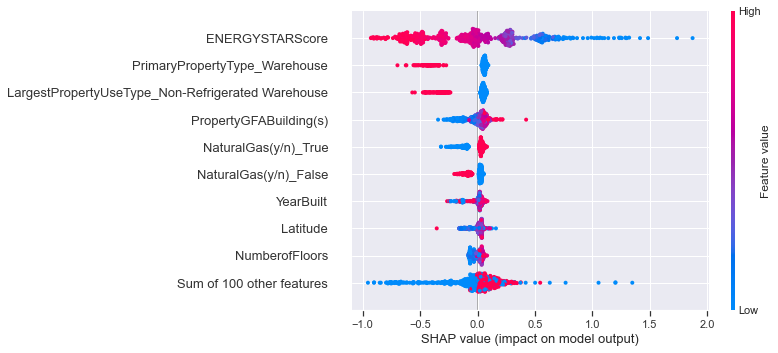

In [69]:
mb00 = model_best.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder']
mb01 = model_best.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler']
mb1 = model_best[1]
model = pipeline_t(mb00, mb01, mb1)
model.fit(Xtr, ytr)
if "OrdinalEncoder" in str(mb00):
    feature_names_2 = np.concatenate((cols_num, cols_cat),axis=0)
else:
    cols_cat_ohe = model.named_steps['preprocessor'].transformers_[1][1]\
        .named_steps['encoder'].get_feature_names(cols_cat)
    feature_names_2 = np.concatenate((cols_num, cols_cat_ohe),axis=0)
X_mod = model[0].fit_transform(Xtr, ytr)
X_mod = pd.DataFrame(X_mod, index=Xtr.index, columns=feature_names_2)
explainer = shap.Explainer(model[1].predict, X_mod)
shap_values = explainer(X_mod)
shap.plots.beeswarm(shap_values)
#shap.summary_plot(shap_values)

>>-
## 55. Scores avec/sans E*score

In [72]:
ypred = model.predict(Xts)
r2_551, mae_551, mse_551 = r2_score(yts, ypred), mean_absolute_error(yts, ypred), mean_squared_error(yts, ypred)

In [73]:
drops = ['ENERGYSTARScore']
X = X.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)

In [74]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

In [76]:
model = pipeline_t(mb00, mb01, mb1)
model.fit(Xtr, ytr)
print()

In [77]:
ypred = model.predict(Xts)
r2_552, mae_552, mse_552 = r2_score(yts, ypred), mean_absolute_error(yts, ypred), mean_squared_error(yts, ypred)

In [79]:
r2_551-r2_552, mae_551-mae_552, mse_551-mse_552

(0.3122003408671221, -0.15786370837036834, -0.1996719988949217)

In [81]:
r2_551, r2_552

(0.6122466721288635, 0.3000463312617414)

In [71]:
r=

SyntaxError: invalid syntax (2666259821.py, line 1)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
nrgies = ['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']
chi2(abs(df[cols_num]), df[nrgies].sum())